## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# load data 
# ----------
import numpy as np
import pandas as pd
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
np.random.seed(42)
congress_tweets = congress_tweets.sample(n=5000)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670"
175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892"
64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843"
553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


Actually, I'm not sure if I should be adding these new columns (below) back into the dataset because I'm only taking a small sample of the dataset. I'll re-think this when I go into Part II of the project.

In [3]:
#Create dictionary for states' 2012 and 2016 election results, store it in dataset because we probably will do some change over time stuff related to RQ2
mappedstates = {}  # Create an empty dictionary to hold state mappings

# Iterate over rows for 2012 data
for index, row in congress_tweets.iterrows():
    if row['obama_2012_state_share'] > row['romney_2012_state_share']:
        mappedstates[row['state']] = ['Democrat2012', None]  # Assign Democrat for 2012
    else:
        mappedstates[row['state']] = ['Republican2012', None]  # Assign Republican for 2012

# Iterate over rows for 2016 data and update mappings
for index, row in congress_tweets.iterrows():
    if row['clinton_2016_state_share'] > row['trump_2016_state_share']:
        mappedstates[row['state']][1] = 'Democrat2016'  # Update 2016 to Democrat
    else:
        mappedstates[row['state']][1] = 'Republican2016'  # Update 2016 to Republican

# Create new columns for party affiliation in 2012 and 2016
congress_tweets['party_2012'] = congress_tweets['state'].map(lambda state: mappedstates.get(state, [None, None])[0])
congress_tweets['party_2016'] = congress_tweets['state'].map(lambda state: mappedstates.get(state, [None, None])[1])

# Check the updated DataFrame
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,party_2012,party_2016
908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670",Democrat2012,Democrat2016
175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892",Democrat2012,Democrat2016
64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Democrat2012,Democrat2016
783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",Republican2012,Republican2016
553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",Democrat2012,Democrat2016


In [4]:
#Play around with formatting of temporal variables
congress_tweets['joined_congress_date'] = pd.to_datetime(congress_tweets['joined_congress_date'], format='%d-%b-%y')

congress_tweets['birthday'] = pd.to_datetime(congress_tweets['birthday'], format='%m/%d/%Y')

congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,party_2012,party_2016
908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,2017-01-03,1965-09-21,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670",Democrat2012,Democrat2016
175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,1999-01-03,1948-07-22,M,CT,1,Democrat,"673,215","897,572","905,083","634,892",Democrat2012,Democrat2016
64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,1987-06-02,1940-03-26,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Democrat2012,Democrat2016
783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,2013-01-03,1974-09-16,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",Republican2012,Republican2016
553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,2018-11-13,1957-04-29,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",Democrat2012,Democrat2016


In [5]:
#Obviously a person's name does not change, even if their screen name does. What we want to do is capture all the screen names associated with a particular individual

# Create a mapping dictionary from 'screen_name' to 'name_wikipedia'
screenname_to_wiki = dict(zip(congress_tweets['screen_name'], congress_tweets['name_wikipedia']))

# Map the dictionary to create the 'mapped_wikipedia' column
congress_tweets['mapped_wikipedia'] = congress_tweets['screen_name'].map(screenname_to_wiki)

# Group by 'mapped_wikipedia' and aggregate 'screen_names' into a list, ensuring uniqueness
screenname_grouped = congress_tweets.groupby('mapped_wikipedia')['screen_name'].apply(lambda x: list(set(x))).reset_index()

# Rename the column in 'screenname_grouped' to 'screen_name_all'
screenname_grouped = screenname_grouped.rename(columns={'screen_name': 'screen_name_all'})

# Merge the aggregated 'screen_name_all' back into the original DataFrame
congress_tweets = congress_tweets.merge(screenname_grouped[['mapped_wikipedia', 'screen_name_all']], 
                                        on='mapped_wikipedia', 
                                        how='left', 
                                        suffixes=('', '_merged'))

# Identify and drop any redundant 'screen_name_all' columns, leaving only the correct one
columns_to_drop = [col for col in congress_tweets.columns if 'screen_name_all' in col and col != 'screen_name_all']
congress_tweets.drop(columns=columns_to_drop, inplace=True)

# Drop the 'mapped_wikipedia' column
congress_tweets.drop(columns='mapped_wikipedia', inplace=True)

# Check results
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,party_2012,party_2016,screen_name_all
0,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,2017-01-03,1965-09-21,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670",Democrat2012,Democrat2016,[RepJayapal]
1,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,1999-01-03,1948-07-22,M,CT,1,Democrat,"673,215","897,572","905,083","634,892",Democrat2012,Democrat2016,[RepJohnLarson]
2,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,1987-06-02,1940-03-26,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Democrat2012,Democrat2016,[SpeakerPelosi]
3,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,2013-01-03,1974-09-16,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",Republican2012,Republican2016,[JoaquinCastrotx]
4,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,2018-11-13,1957-04-29,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",Democrat2012,Democrat2016,[RepJoeMorelle]


In [6]:
# Filter rows where 'screen_name_all' contains more than one screen name
multiple_screen_names = congress_tweets[congress_tweets['screen_name_all'].apply(len) > 1]

# Display rows with multiple screen names
print(multiple_screen_names[['screen_name_all']])


Empty DataFrame
Columns: [screen_name_all]
Index: []


Lol, so there seem to be no updated screen names in this sample, I'm going to keep this code though, since the project PDF indicated that there will be different screen names for the same individual in some cases.

In [7]:
#Trying this on Kamala Harris since her position changed
specific_rows = congress_tweets[congress_tweets['name_wikipedia'] == 'Kamala Harris'][['screen_name', 'name_wikipedia']]

# Print the selected columns
print(specific_rows)

          screen_name name_wikipedia
80    SenKamalaHarris  Kamala Harris
86    SenKamalaHarris  Kamala Harris
486   SenKamalaHarris  Kamala Harris
498   SenKamalaHarris  Kamala Harris
658   SenKamalaHarris  Kamala Harris
792   SenKamalaHarris  Kamala Harris
817   SenKamalaHarris  Kamala Harris
870   SenKamalaHarris  Kamala Harris
1111  SenKamalaHarris  Kamala Harris
1711  SenKamalaHarris  Kamala Harris
2251  SenKamalaHarris  Kamala Harris
2408  SenKamalaHarris  Kamala Harris
2425  SenKamalaHarris  Kamala Harris
3210  SenKamalaHarris  Kamala Harris
4098  SenKamalaHarris  Kamala Harris
4300  SenKamalaHarris  Kamala Harris
4460  SenKamalaHarris  Kamala Harris
4681  SenKamalaHarris  Kamala Harris
4756  SenKamalaHarris  Kamala Harris


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [8]:
##this pretty unelegant but I basically kept adding stuff to be removed each time I went back to the tweets and found something
import html
import spacy
import re
from string import punctuation

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

def rem_punc_stop(text):
    stop_words = STOP_WORDS  # List of common stopwords in English
    punc = set(punctuation)  # Set of punctuation characters
    
    # Decode HTML escape codes like &amp;
    text = html.unescape(text)  # Decode other HTML escape codes like &lt;, &gt;, etc.
    text = text.replace('&', '')  # Manually remove '&' symbol
    
    # Remove newline characters and unnecessary whitespaces
    text = text.replace('\n', ' ').strip()
    
    # Remove URLs using regex before SpaCy tokenization
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)  # Removes URLs like http://, https://, www.*
    
    # Remove punctuation (except mentions)
    punc_free = "".join([ch for ch in text if ch not in punc or ch == '@'])  # Keep @ for mentions
    
    # Process the text with SpaCy
    doc = nlp(punc_free)

    # Get all words, excluding URLs using the 'like_url' attribute from SpaCy
    spacy_words = [token.text for token in doc if not token.like_url]  # Excludes URLs
    
    # Remove empty strings or unwanted space tokens
    spacy_words = [word for word in spacy_words if word.strip()]
    
    # Remove the word 'nt' specifically
    spacy_words = [word for word in spacy_words if word.lower() != 'nt']
    
    # Filter out stop words and convert to lowercase
    no_punc = [word for word in spacy_words if word.lower() not in stop_words]
    
    return no_punc


In [9]:
# Test tweet
tweet_text = """It doesn't matter the topic- from standing up for #civilrights &amp; #sexualassault survivors to regulating #forprofitcolleges- @BetsyDeVosED sides with the lenders and the corporations- not students. She is working against the mission of the @usedgov. https://twitter.com/RepKClark/status/1108874640838049792 QT @RepKClark For the 2nd year in a row, the @StateDept erased #reproductivehealth- maternal and comprehensive care- from the annual #humanrights report. I filed a bill to demand they treat women's health for what it is: a #humanright. https://twitter.com/RepKClark/status/1108872716264882176"""

# Apply the function to the tweet_text
cleaned_text = rem_punc_stop(tweet_text)

# Print the cleaned text
print(cleaned_text)

['matter', 'topic', 'standing', 'civilrights', 'sexualassault', 'survivors', 'regulating', 'forprofitcolleges', '@BetsyDeVosED', 'sides', 'lenders', 'corporations', 'students', 'working', 'mission', '@usedgov', 'QT', '@RepKClark', '2nd', 'year', 'row', '@StateDept', 'erased', 'reproductivehealth', 'maternal', 'comprehensive', 'care', 'annual', 'humanrights', 'report', 'filed', 'bill', 'demand', 'treat', 'womens', 'health', 'humanright']


In [10]:
# apply the function to the 'text' i.e. tweet column
# ----------
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # can use apply here 
congress_tweets['tokens'] # visualize

0       [RT, @RepKClark, 22, million, Americans, filed...
1               [Thanks, came, tonight, forum, GOPTaxLaw]
2       [RT, @RepFilemonVela, Dreamers, TPS, recipient...
3       [RT, @HispanicCaucus, @JoaquinCastrotx, @TheBl...
4       [Thank, @NYGovCuomo, today, face, extreme, wea...
                              ...                        
4995    [RT, @SenatorBraun, officially, ALSAwarenessMo...
4996    [Powerful, words, today, friend, colleague, @S...
4997    [RT, @Ch2KTUU, Alaska, Senator, Dan, Sullivan,...
4998    [Open, schools, QT, @kyoag, Today, 38, Senator...
4999    [Great, news, @ConnectTransit, week, @RodneyDa...
Name: tokens, Length: 5000, dtype: object

In [11]:
#!git status

In [12]:
#!git add "Taylor Updates Project 5 Student.ipynb"

In [13]:
#!git status

In [14]:
#!git commit -m "New commits"

In [15]:
#!git push

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

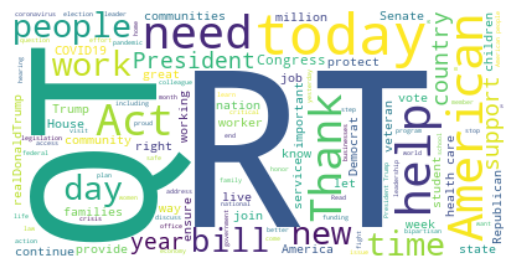

In [16]:
# apply function to text object
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(text)             # change the background color


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

Looks like retweets and quote tweets are pretty prevalent, along with a number of relatively unsurprising words such as today, American, president, need, etc. Interesting that Trump is so prevalent, I'm wondering how old this dataset is (i.e. proportionally how much people talk about Trump relative to how long he's been in the political spotlight).

### EDA 2-ish

### Retweets and Quote Tweets

I think that retweets and quote tweets are meaningful signals, though we might not want to have them messing up our sentiment analysis. 
First, let's pull them out to see how prevalent they actually are (reminding ourselves that this is a small subset of our very large dataset)

In [17]:
# Find all tweets containing "RT" or "QT"
RTtweets = congress_tweets[congress_tweets['text'].str.contains('RT', na=False)]
QTtweets = congress_tweets[congress_tweets['text'].str.contains('QT', na=False)]

# Print the count of retweets and quote tweets
print(f"Number of tweets containing Retweets: {RTtweets.shape[0]}")
print(f"Number of tweets containing Quote tweets: {QTtweets.shape[0]}")

Number of tweets containing Retweets: 1223
Number of tweets containing Quote tweets: 715


Now there are some analytic choices here. 
For quote tweets, we will probably need to conceptualize this as a conversation, where the sentiment/message of the original tweet could ostensibly be the opposite of the re-poster. (I.e. "I can't believe that this person said this!"
However, should 'simple' re-tweets be considered representative of the person doing the re-tweeting? (I.e. emphasizing/affirming the encapsulated idea? )
Or should they be attributed to the original speaker/author(s) instead? What should we do if multiple people are being referenced?
Let's see if people are re-tweeting/quote-tweeting other individuals who are also in our database. As we can only reasonably infer characteristics (e.g. political party) about people being re-tweeted if they are in our database already.

In [18]:
repost_users = congress_tweets[congress_tweets['text'].str.contains('@', na=False)]

print(repost_users[['text']].head())

# Print the count of tweets with an @
print(f"Total number of tweets containing an @: {repost_users.shape[0]}")

                                                text
0  RT @RepKClark 22 million Americans filed for u...
2  RT @RepFilemonVela #Dreamers &amp; TPS recipie...
3  RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...
4  Thank you to @NYGovCuomo for being here today ...
5  .@RepRubenGallego and I are urging companies w...
Total number of tweets containing an @: 2916


In [19]:
import re

mentionedusers = {}  # Create an empty dictionary to hold mentions and associated tweet text

# Iterate over rows of congress_tweets
for index, row in congress_tweets.iterrows():
    # Extract mentions (users starting with @) from the tweet text
    mentions = re.findall(r'@([a-zA-Z0-9_]+)', row['text'])
    
    # Check if any of the mentions are in the congress_tweets['original_screen_name'] list
    for mention in mentions:
        if mention in congress_tweets['screen_name'].values:
            # Find the political affiliation of the person doing the mentioning (the tweet author)
            mentioner_affiliation = congress_tweets.loc[congress_tweets['screen_name'] == row['screen_name'], 'party'].values[0]
            
            # Find the political affiliation of the person being mentioned
            mentioned_affiliation = congress_tweets.loc[congress_tweets['screen_name'] == mention, 'party'].values[0]
            
            # Store the tweet text, the mentioner’s political affiliation, and the mentioned person’s political affiliation in the dictionary
            mentionedusers[mention] = {
                'mentioner_screen_name': row['screen_name'],  # Add mentioner's screen name
                'mentioner_text': row['text'],
                'mentioner_affiliation': mentioner_affiliation,
                'mentioned_affiliation': mentioned_affiliation
            }

# Print only the first 5 mentions that are in congress_tweets['original_screen_name'], including political affiliation and the tweet author
for i, (mention, details) in enumerate(mentionedusers.items()):
    if i >= 5:
        break
    print(f"Tweet Author: {details['mentioner_screen_name']}")
    print(f"Author Political Affiliation: {details['mentioner_affiliation']}")
    print(f"Mentioned User: {mention}")
    print(f"Mentioned User Political Affiliation: {details['mentioned_affiliation']}\n")
    print(f"Tweet Text: {details['mentioner_text']}")
    print("_________")
    
print(f"Number of mentions of people in our dataset: {len(mentionedusers)}")


Tweet Author: RepKClark
Author Political Affiliation: Democrat
Mentioned User: RepKClark
Mentioned User Political Affiliation: Democrat

Tweet Text: RT @MaldenPublic Senior Angela Tejada-Soliz nominated by Congresswoman Katherine Clark for West Point is going to the State of the Union address as a guest of Ms Clark!! ⁦@MayorOfMalden⁩ ⁦@MaldenHS_Sports⁩ ⁦@MHSBlueandGold⁩ ⁦@RepKClark⁩ ⁦⁦ http://pbs.twimg.com/media/DyMxlRDWoAAh0u7.jpg
_________
Tweet Author: RepFilemonVela
Author Political Affiliation: Democrat
Mentioned User: RepFilemonVela
Mentioned User Political Affiliation: Democrat

Tweet Text: RT @DallasFed Dialogue with the Fed: @RepFilemonVela discusses economic growth in Texas with @DallasFed President @RobSKaplan. The moderated discussion will be livestreamed beginning at 11:45 a.m. CT. Join us for an engaging conversation. https://youtu.be/lyc7wx-o9kg
_________
Tweet Author: RepLoriTrahan
Author Political Affiliation: Democrat
Mentioned User: JoaquinCastrotx
Mentioned User Pol

From this, we can see the different ways users are interacting with one another in the form of @'s, retweets, and quote tweets. From even this preview, we can see that it's probably more likely that people are interacting with users of the same political party, and also that we might have some instances where the person re-tweeting is also the mentioned user. In the latter case, I think it's probably safe to assume that the re-poster would endorse the sentiment of the original tweet. 

## EDA 3

In [20]:
# ---------- 
!pip install scattertext

In [21]:
#import scattertext as st
#import pandas as pd
#import spacy
# create measure of subjectivity
# Load SpaCy model
#nlp = spacy.load("en_core_web_sm")

#congress_tweets['tokens'] = congress_tweets['text'].apply(lambda x: [token.text for token in nlp(x) if not token.is_stop and not token.is_punct])
#congress_tweets['tokens_str'] = congress_tweets['tokens'].apply(lambda x: ' '.join(x))

# Create the Corpus for Scattertext
#corpus = st.CorpusFromPandas(
  #  congress_tweets,              
  #  category_col='party',         
  #  text_col='tokens_str',      
  #  nlp=nlp                      
#).build()

# create html document
#html = st.produce_scattertext_explorer(
    #corpus,
    #category='Republican',             
    #category_name='Republican',        
   # not_category_name='Democrat',      
   # width_in_pixels=1000,              
   # minimum_term_frequency=5,         
   # metadata=congress_tweets['position']  
#)

# write html document to memory and open in browser
#with open("Congress_Tweets_Sentiment.html", 'wb') as f:
 #   f.write(html.encode('utf-8'))

#print("Congress_Tweets_Sentiment.html")


In [22]:
#open("Congress_Tweets_Sentiment.html", 'wb').write(html.encode('utf-8'))

In [23]:
#The most significant thing I'm seeing from this is that there's a lot more cleaning I'll have to do (emojis, state abbreviations, etc) I'm not really sure how to clean out emojis, or if I can leave them in?

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [26]:
# create a feature column of sentiment polarity and subjectivity
# ---------- 
# create the "tokens" column again 
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))

# Join the tokens into a single string before applying TextBlob
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda tokens: ' '.join(tokens))

# create the "polarity" column 
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)

# create the "subjectivity" column again 
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# view
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,party_2012,party_2016,screen_name_all,tokens,polarity,subjectivity
0,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,2017-01-03,1965-09-21,F,WA,...,"1,221,747","1,742,718","1,755,396","1,290,670",Democrat2012,Democrat2016,[RepJayapal],RT @RepKClark 22 million Americans filed unemp...,0.350000,0.800000
1,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,1999-01-03,1948-07-22,M,CT,...,"673,215","897,572","905,083","634,892",Democrat2012,Democrat2016,[RepJohnLarson],Thanks came tonight forum GOPTaxLaw,0.200000,0.200000
2,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,1987-06-02,1940-03-26,F,CA,...,"4,483,814","8,753,792","7,854,285","4,839,958",Democrat2012,Democrat2016,[SpeakerPelosi],RT @RepFilemonVela Dreamers TPS recipients ess...,0.000000,0.300000
3,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,2013-01-03,1974-09-16,M,TX,...,"4,685,047","3,877,868","3,308,124","4,569,843",Republican2012,Republican2016,[JoaquinCastrotx],RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,0.000000,1.000000
4,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,2018-11-13,1957-04-29,M,NY,...,"2,819,533","4,556,118","4,485,741","2,490,431",Democrat2012,Democrat2016,[RepJoeMorelle],Thank @NYGovCuomo today face extreme weather s...,0.208333,0.583333


Let's see the list of democrats and republicans in our dataset to see who to choose for this sentiment analaysis. (We're just going to map liberal and conservative along party lines for the purposes of this project, that's a big assumption, though.)

## Finding liberal and conservative members - Nancy Pelosi and Ted Cruz

In [27]:
# List of democrats
democrats = congress_tweets[congress_tweets['party'] == 'Democrat'][['screen_name', 'state']]

# Print the selected columns
print(democrats)

# List of republicans
republicans = congress_tweets[congress_tweets['party'] == 'Republican'][['screen_name', 'state']]

# Print the selected columns
print(republicans)


          screen_name state
0          RepJayapal    WA
1       RepJohnLarson    CT
2       SpeakerPelosi    CA
3     JoaquinCastrotx    TX
4       RepJoeMorelle    NY
...               ...   ...
4989    RepAngieCraig    MN
4991        SenMarkey    MA
4993    RepJohnLarson    CT
4994      RepFletcher    TX
4995       ChrisCoons    DE

[3261 rows x 2 columns]
          screen_name state
6      RepAndyBiggsAZ    AZ
9     CongMikeSimpson    ID
10        RepJimBanks    IN
12     RepBillJohnson    OH
13         JohnCornyn    TX
...               ...   ...
4992       SenTedCruz    TX
4996  AustinScottGA08    GA
4997   SenDanSullivan    AK
4998         RandPaul    KY
4999        RepLaHood    IL

[1705 rows x 2 columns]


Let's choose Nancy Pelosi as our liberal (lol) and Ted Cruz as our conservative. 

In [33]:
pelositweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Nancy Pelosi']
pelositweets = pd.DataFrame(pelositweets) 
cruztweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Ted Cruz']
cruztweets = pd.DataFrame(cruztweets) 

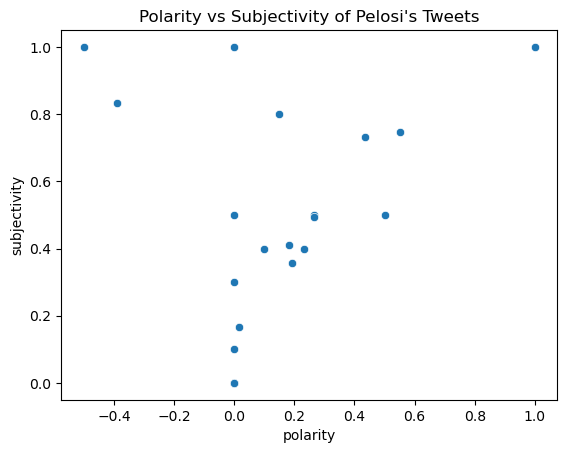

In [39]:
sns.scatterplot(data=pelositweets, x="polarity", y="subjectivity")
plt.title("Polarity vs Subjectivity of Pelosi's Tweets")
plt.show()

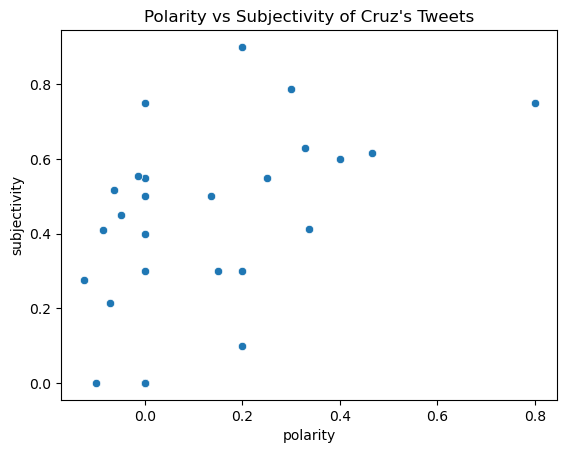

In [40]:
sns.scatterplot(data=cruztweets, x="polarity", y="subjectivity")
plt.title("Polarity vs Subjectivity of Cruz's Tweets")
plt.show()

## Democrats vs. Republicans

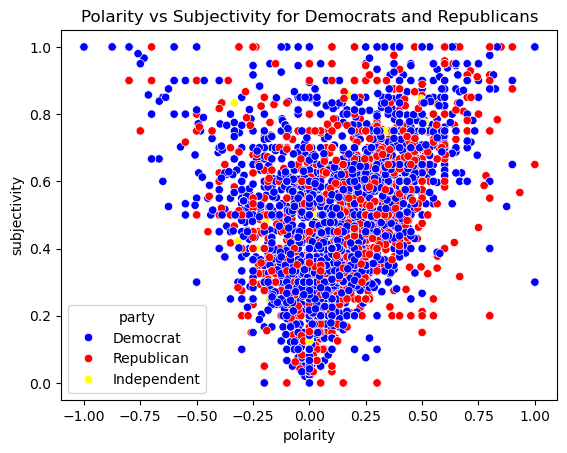

In [45]:
# Create the scatter plot
# Define a custom color palette: Blue for Democrats, Red for Republicans
party_palette = {'Democrat': 'blue', 'Republican': 'red', 'Independent': 'yellow'}
sns.scatterplot(data=congress_tweets, x="polarity", y="subjectivity", hue="party", palette=party_palette)

# Add plot title and show the plot
plt.title("Polarity vs Subjectivity for Democrats and Republicans")
plt.show()

## Senators vs. Representatives

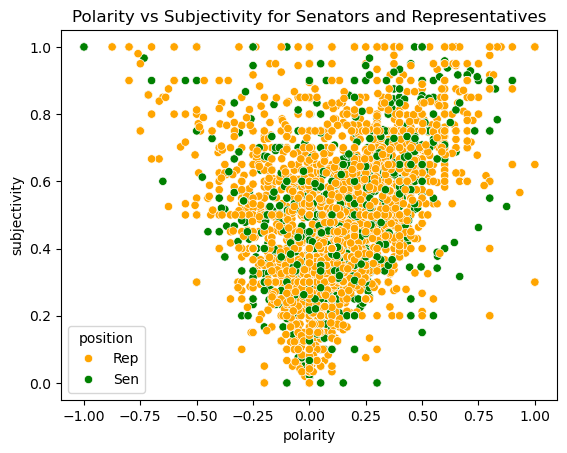

In [46]:
# Create the scatter plot
# Define a custom color palette: Blue for Democrats, Red for Republicans
position_palette = {'Rep': 'orange', 'Sen': 'green'}
sns.scatterplot(data=congress_tweets, x="polarity", y="subjectivity", hue="position", palette=position_palette)

# Add plot title and show the plot
plt.title("Polarity vs Subjectivity for Senators and Representatives")
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features - sentiment scores

In [48]:
#Engineered features
sentimentdf = congress_tweets

### Tf-idf

In [52]:

# create tf-idf matrix
# ----------
# set X dataset
X = congress_tweets['text']        

# initialize tf-idf using our preprocessing function
tf = TfidfVectorizer(tokenizer = rem_punc_stop, # use our function for tokenizing created above
                     token_pattern = None, # set to "None" since we have specify our own pattern
                    max_features=500)      # limit to top 500 features

# fit and transform data
tfidf_matrix =  tf.fit_transform(X)

# create dense matrix just to view
dense_matrix = tfidf_matrix.todense()
dense_matrix 

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
# create a useful visualization of tf-idf matrix
# ----------

# convert matrix to an arrray and then to a dataframe
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(),       # convert to array than to datafram
                         columns=tf.get_feature_names_out()) # specify column names as feature names from TF vectorizer

# sort by term frequency on the first document
tfidf_df.T.nlargest(10,  # transpose the matrix = columns become documents and rows are words
                     0)  # on column index 0 to show the largest

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
continues,0.346609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
policies,0.339707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
southwest,0.316388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
economy,0.313467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
economic,0.306715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
washington,0.280079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
county,0.267665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
continue,0.259677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
support,0.248714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
proud,0.248214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Embedding

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [56]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [61]:
# embedding based featurization
# apply CBOW Word2vec model to our congress_tweets data 
# ----------
model = gensim.models.Word2Vec(congress_tweets['tokens'],    # specify data - sentences
                               vector_size=100,   # set embedding size at 100
                               window=5,          # max distance between current and predicted word
                               min_count=5,       # ignores words with freq fewer than this threshold
                               sg=0,              # specify Continuous Bag of Words Algorithim
                               alpha=0.025,       # learning rate
                               epochs = 5,        # iterations
                               seed = 1,          # set random seed (same as random_state in sklearn )
                               batch_words=10000, # sample size 
                               workers = 1)       # set cores to 1 to ensure this embeddings are fully reproducible



In [62]:
# return embeddings for specific word
# ----------
print(model.wv.__getitem__(['policies'])) # specify a key word here: "policies"

[[-3.09618086e-01  4.57664788e-01  4.93678600e-02  2.89362729e-01
  -3.83903272e-04 -6.15650713e-01  1.89766005e-01  6.15572214e-01
  -9.73114893e-02 -7.83711672e-02 -2.15324670e-01 -7.50020087e-01
  -1.30993873e-01  1.92427307e-01  3.16753745e-01 -3.20961446e-01
   1.11779287e-01 -5.82839131e-01 -9.88632068e-02 -6.93238556e-01
   3.65477741e-01  1.90147564e-01  1.57037511e-01 -2.65023321e-01
  -2.51021013e-02  1.89900771e-01 -2.31720015e-01 -1.61368415e-01
  -4.04391915e-01 -2.61088997e-01  5.78755677e-01  5.77416830e-03
   1.25947416e-01 -1.06046304e-01 -3.06250572e-01  1.48811713e-01
   4.49800193e-01 -3.59329283e-01 -2.23049179e-01 -5.58665097e-01
   1.31200805e-01 -3.06807160e-01 -1.98876217e-01  7.99164828e-03
   2.46265620e-01 -4.45862114e-02 -4.10042197e-01 -1.02750279e-01
   3.65367383e-02  3.62147123e-01  9.41479132e-02 -3.43114704e-01
  -2.34931558e-01  9.08691343e-03 -3.60388637e-01  1.41283587e-01
   2.20921561e-01 -7.63523579e-03 -3.75313431e-01  6.42901137e-02
   7.87925

In [63]:
# Extract words and their corresponding vectors
words = list(model.wv.index_to_key)  # All words in the vocabulary
vectors = [model.wv[word] for word in words]  # List of word vectors

# Create a DataFrame where each row corresponds to a word and its vector
word_vectors_df = pd.DataFrame(vectors, index=words)

# Print the DataFrame to see the word vectors
print(word_vectors_df.head())

               0         1         2         3         4         5         6   \
RT      -0.518472  0.839568  0.094745  0.565684 -0.016655 -1.095515  0.365276   
Alabama -0.536199  0.769560  0.109822  0.441150  0.021777 -1.012333  0.320477   
today   -0.465524  0.716299  0.078604  0.403165  0.028042 -0.907000  0.290963   
QT      -0.589059  0.916887  0.097942  0.558103  0.016836 -1.205092  0.387430   
AL03    -0.434538  0.638598  0.063904  0.360484  0.027728 -0.814107  0.269660   

               7         8         9   ...        90        91        92  \
RT       1.179826 -0.203078 -0.206163  ...  0.528750  0.578523  0.112595   
Alabama  1.010964 -0.176068 -0.143167  ...  0.488337  0.568122  0.121758   
today    0.930663 -0.185653 -0.127786  ...  0.449364  0.532468  0.125502   
QT       1.237033 -0.191567 -0.198682  ...  0.572416  0.662483  0.138078   
AL03     0.835834 -0.160150 -0.110817  ...  0.421705  0.461275  0.119054   

               93        94        95        96        9

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**YOUR ANSWER HERE** ...

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**YOUR ANSWER HERE** ...

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**YOUR ANSWER HERE** ...

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**YOUR ANSWER HERE** ...